In [1]:
import os
import glob
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn import metrics
import matplotlib.pyplot as plt
import json
import matplotlib.image as mpimg
from sklearn import mixture
import umap

In [2]:
def plot_variance(data, name, cutoff = 0.95):
    pca = PCA().fit(data)
    plt.rcParams["figure.figsize"] = (16,6)

    fig, ax = plt.subplots()
    xi = np.arange(0, 200, step = 1)
    y = np.cumsum(pca.explained_variance_ratio_)

    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker='o', linestyle='--', color='b')

    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative variance (%)')
    plt.title('The number of components needed to explain variance')

    plt.axhline(y=cutoff, color='r', linestyle='-')
    plt.text(0.5, 0.85, f'{int(cutoff*100)}% cut-off threshold', color = 'red', fontsize=16)

    ax.grid(axis='x')
    plt.savefig(f'img/pca-components-{name}.png')
    plt.clf()
    
def apply_pca(data, name):
    # 96% of variance
    plot_variance(data, name, 0.96)
    pca = PCA(n_components = 0.96)
    pca.fit(data)
    data_reduced = pca.transform(data)
    components = data_reduced.shape[1]
    print(f'PCA chosen components: {components}')
    return data_reduced

def apply_tsne(data, name):
    p = np.sqrt(len(data)) #power law obtained from experiment(cite)
    n = 1000
    comps = 3
    tsne = TSNE(n_components = comps, verbose=0, perplexity = p, n_iter = n)
    data_reduced = tsne.fit_transform(data, )
    print(f'TSNE components: {comps}')
    plot_tsne_results(data_reduced, name, method="tsne")
    return data_reduced


umap_parameters = {
    "dataset1": {"n_neighbors": 10, "n_components": 2, "min_dist": 0.01},
    "dataset2": {"n_neighbors": 5, "n_components": 2, "min_dist": 0.1},
    "dataset3": {"n_neighbors": 10, "n_components": 3, "min_dist": 0.01},
    "dataset4": {"n_neighbors": 5, "n_components": 3, "min_dist": 0.01},
    "dataset5": {"n_neighbors": 5, "n_components": 2, "min_dist": 0.01},
}

def apply_umap(data, name):
    metric = "euclidean"
    params = umap_parameters[name]
    n_neighbors = params["n_neighbors"]
    min_dist = params["min_dist"]
    n_components = params["n_components"]
    reducer = umap.UMAP(n_neighbors=n_neighbors,
                    min_dist=min_dist,
                    n_components=n_components,
                    metric=metric)
    data_reduced = reducer.fit_transform(data)
    return data_reduced

def plot_umap_results(umap_data, name):
    i1 = 0
    j1 = 0
    k = 0
    i2 = 0
    j2 = 0
    fig1, axs1 = plt.subplots(4, 3, figsize=(30, 20))
    fig2, axs2 = plt.subplots(4, 3, figsize=(30, 20))
    fig1.suptitle(f"UMAP on {name} different settings for 2 components", fontsize=24)
    fig2.suptitle(f"UMAP on {name} different settings for 3 components", fontsize=24)
    for setting in umap_data.keys():
        n_neighbors, min_dist, n_components = setting.split("_")
        projections = np.array(umap_data[setting]) 
        if(n_components == "2"):
            axs1[i1, j1].set_title(f"No. of neighbors {n_neighbors}, min. distance {min_dist}, components {n_components}")
            axs1[i1, j1].scatter(projections[:,0], projections[:,1])
            if(j1 == 2):
                i1 += 1
                j1 = 0
            else:
                j1 += 1
        elif(n_components == "3"):
            k += 1
            axs2[i2, j2].axis('off')
            ax2 = fig2.add_subplot(4, 3, k, projection='3d')
            ax2.set_title(f"No. of neighbors {n_neighbors}, min. distance {min_dist}, components {n_components}")
            ax2.scatter3D(projections[:,0], projections[:,1], projections[:,2])
            if(j2 == 2):
                i2 += 1
                j2 = 0
            else:
                j2 += 1

    plt.show()

def test_umap(data, name):
    # its defaults i 2 dimensions
    if(os.path.exists(f"output/test_umap_{name}.json")):
        out_file = open(f"output/test_umap_{name}.json", "r")
        umap_data = json.load(out_file)
    else:
        n_neighbors_list = [5, 10, 25, 50] 
        min_dist_list = [0.01, 0.1, 1]
        n_components_list = [2, 3]
        metric = "euclidean"
        umap_data = {}
        for n_neighbors in n_neighbors_list:
            for min_dist in min_dist_list:
                for n_components in n_components_list:
                    reducer = umap.UMAP(n_neighbors=n_neighbors,
                        min_dist=min_dist,
                        n_components=n_components,
                        metric=metric)
                    data_reduced = reducer.fit_transform(data)
                    n = str(n_neighbors) + "_" + str(min_dist) + "_" + str(n_components)
                    umap_data[n] = data_reduced.tolist()
        out_file = open(f"output/test_umap_{name}.json", "w")
        json.dump(umap_data, out_file)
    plot_umap_results(umap_data, name)

    
def plot_tsne_results(projections, name, method):
    dims = projections.shape[1]
    if(dims == 2):
        plt.title(f"Dimensionality Reduction results on {name} using {method}")
        plt.scatter(projections[:,0], projections[:,1])
        plt.savefig(f"img/{method}/{name}-2.png")
    elif(dims == 3):
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.set_title(f"Dimensionality Reduction results on {name} using {method}")
        ax.scatter3D(projections[:,0], projections[:,1], projections[:,2])
        plt.savefig(f"img/{method}/{name}-3.png")
    plt.clf()
    
def dimensionality_reduction(df, name, func = 'all'):
    data_rescaled = MinMaxScaler().fit_transform(df)  
    data_reduced = data_rescaled
    if func == 'pca':
        data_reduced = apply_pca(data_rescaled, name)
    elif func == 'tsne':
        data_reduced = apply_pca(data_rescaled, name)
        data_reduced = apply_tsne(data_rescaled, name)
    elif func == 'umap':
        data_reduced = apply_pca(data_rescaled, name)
        data_reduced = apply_umap(data_reduced, name)
    elif func == 'test-umap':
        data_reduced = apply_pca(data_rescaled, name)
        data_reduced = test_umap(data_reduced, name)
    elif func == 'all':
        data_reduced = apply_pca(data_rescaled, name)
        data_reduced = apply_tsne(data_reduced, name)
        data_reduced = apply_umap(data_reduced, name)
    else:
        print("Unknown function parameter")
    return data_reduced



In [26]:
def gmm_kl(gmm_p, gmm_q, n_samples=10**2):
    X = gmm_p.sample(n_samples)[0]
    log_p_X, _ = gmm_p.score_samples(X)
    log_q_X, _ = gmm_q.score_samples(X)
    return log_p_X.mean() - log_q_X.mean()

def gmm_js(gmm_p, gmm_q, n_samples=10**2):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return (log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2

def gmm_distance(data, axs):
    # split data in two random halfs
    p, q = np.split(data, 2)
    js = []
    # compute gmms
    for n in np.arange(2, 20):
        gmm_p = mixture.GaussianMixture(n_components = n, covariance_type='full').fit(p)
        labels = gmm_p.predict(data)

        gmm_q = mixture.GaussianMixture(n_components = n, covariance_type='full').fit(q)
        labels = gmm_q.predict(data)
    
        # find the Jensen-Shannon metric of the gmms
        js.append(gmm_js(gmm_p, gmm_q))
    
    # plot it
    axs[0][1].plot(np.arange(2, 20), js)
    axs[0][1].set_xticks(np.arange(2, 20))
    #axs[0][1].set_xticks([2, 5, 10, 15, 20])
    #axs[0][1].set_xlabel("No. of Clusters")
    axs[0][1].set_ylabel("Score")
    axs[0][1].set_title("Jensen-Shannon Metrics")

def silhouette_scores(data, axs):
    silhouettes = [] 
    for n in np.arange(2, 20):
        gmm = mixture.GaussianMixture(n_components = n, covariance_type='full').fit(data)
        labels = gmm.predict(data)
        sil = metrics.silhouette_score(data, labels, metric="sqeuclidean")
        silhouettes.append(sil)
    
    axs[0][0].plot(np.arange(2, 20), silhouettes)
    #axs[0][0].set_xticks([2, 5, 10, 15, 20])
    axs[0][0].set_xticks(np.arange(2, 20))
    #axs[0][0].set_xlabel("No. of Clusters")
    axs[0][0].set_ylabel("Score")
    axs[0][0].set_title("Silhouette Scores")

def bic(data, axs):
    bics = []
    for n in np.arange(2, 20):
        gmm = mixture.GaussianMixture(n_components = n, covariance_type='full').fit(data)
        b = gmm.bic(data)
        bics.append(b)
    axs[1][0].plot(np.arange(2, 20), bics)
    #axs[1][0].set_xticks([2, 5, 10, 15, 20])
    axs[1][0].set_xticks(np.arange(2, 20))
    axs[1][0].set_ylabel("BIC")
    axs[1][0].set_title("BIC Scores")
    axs[1][1].plot(np.arange(2, 20), np.gradient(bics))
    #axs[1][0].set_xticks([2, 5, 10, 15, 20])
    axs[1][1].set_xticks(np.arange(2, 20))
    axs[1][1].set_ylabel("BIC Gradient")
    axs[1][1].set_title("BIC Gradient Scores")
    
def aic(data, axs):
    aics = []
    for n in np.arange(2, 20):
        gmm = mixture.GaussianMixture(n_components = n, covariance_type='full').fit(data)
        b = gmm.aic(data)
        aics.append(b)
    axs[2][0].plot(np.arange(2, 20), aics)
    #axs[1][0].set_xticks([2, 5, 10, 15, 20])
    axs[2][0].set_xticks(np.arange(2, 20))
    axs[2][0].set_xlabel("No. of Clusters")
    axs[2][0].set_ylabel("AIC")
    axs[2][0].set_title("AIC Scores")
    axs[2][1].plot(np.arange(2, 20), np.gradient(aics))
    #axs[1][0].set_xticks([2, 5, 10, 15, 20])
    axs[2][1].set_xticks(np.arange(2, 20))
    axs[2][1].set_xlabel("No. of Clusters")
    axs[2][1].set_ylabel("AIC Gradient")
    axs[2][1].set_title("AIC Gradient Scores")
        
def score(data, name):
    bests = []
    fig, axs = plt.subplots(3, 2, figsize=(16, 10), sharex=True)
    fig.suptitle(f"Clustering Scores for {name}", fontsize=24)
    bests.append(silhouette_scores(data, axs))
    bests.append(gmm_distance(data, axs))
    bests.append(bic(data, axs))
    bests.append(aic(data, axs))
    plt.show()
    plt.clf()
    return 2
    
def cluster(data, name, mode):
    best = score(data, name)
    if mode != 'test':
        gmm_best = mixture.GaussianMixture(n_components = best, covariance_type='full').fit(data)
        labels = gmm_best.predict(data)

        plt.scatter(data[:, 0], data[:, 1], c=labels, s=40, cmap='viridis');

In [30]:
def test(df, name, test = 'dr'):
    if(test == 'dr'):
        dimensionality_reduction(df, name, 'tsne')
        data_reduced = dimensionality_reduction(df, name, 'test-umap')
    else:
        data_reduced = dimensionality_reduction(df, name, 'umap')
        cluster(data_reduced, name, 'test')

def pipeline(df, name):
    data_reduced = dimensionality_reduction(df, name, 'umap')
    cluster(data_reduced, name)

In [28]:
def run(mode, test_mode):
    data_path = "data"
    data_files = glob.glob('{}/*.csv'.format(data_path))
    for i, data_file in enumerate(data_files):
        name = "dataset" + str(i + 1)
        df = pd.read_csv(data_file, index_col = 0)
        if(mode == 'test'):
            test(df, name, test_mode)
        else:
            pipeline(df, name)

PCA chosen components: 116


/Users/vasilisstamatopoulos/opt/anaconda3/envs/ml_comp_bio/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/vasilisstamatopoulos/opt/anaconda3/envs/ml_comp_bio/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


TSNE components: 3
PCA chosen components: 116


<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

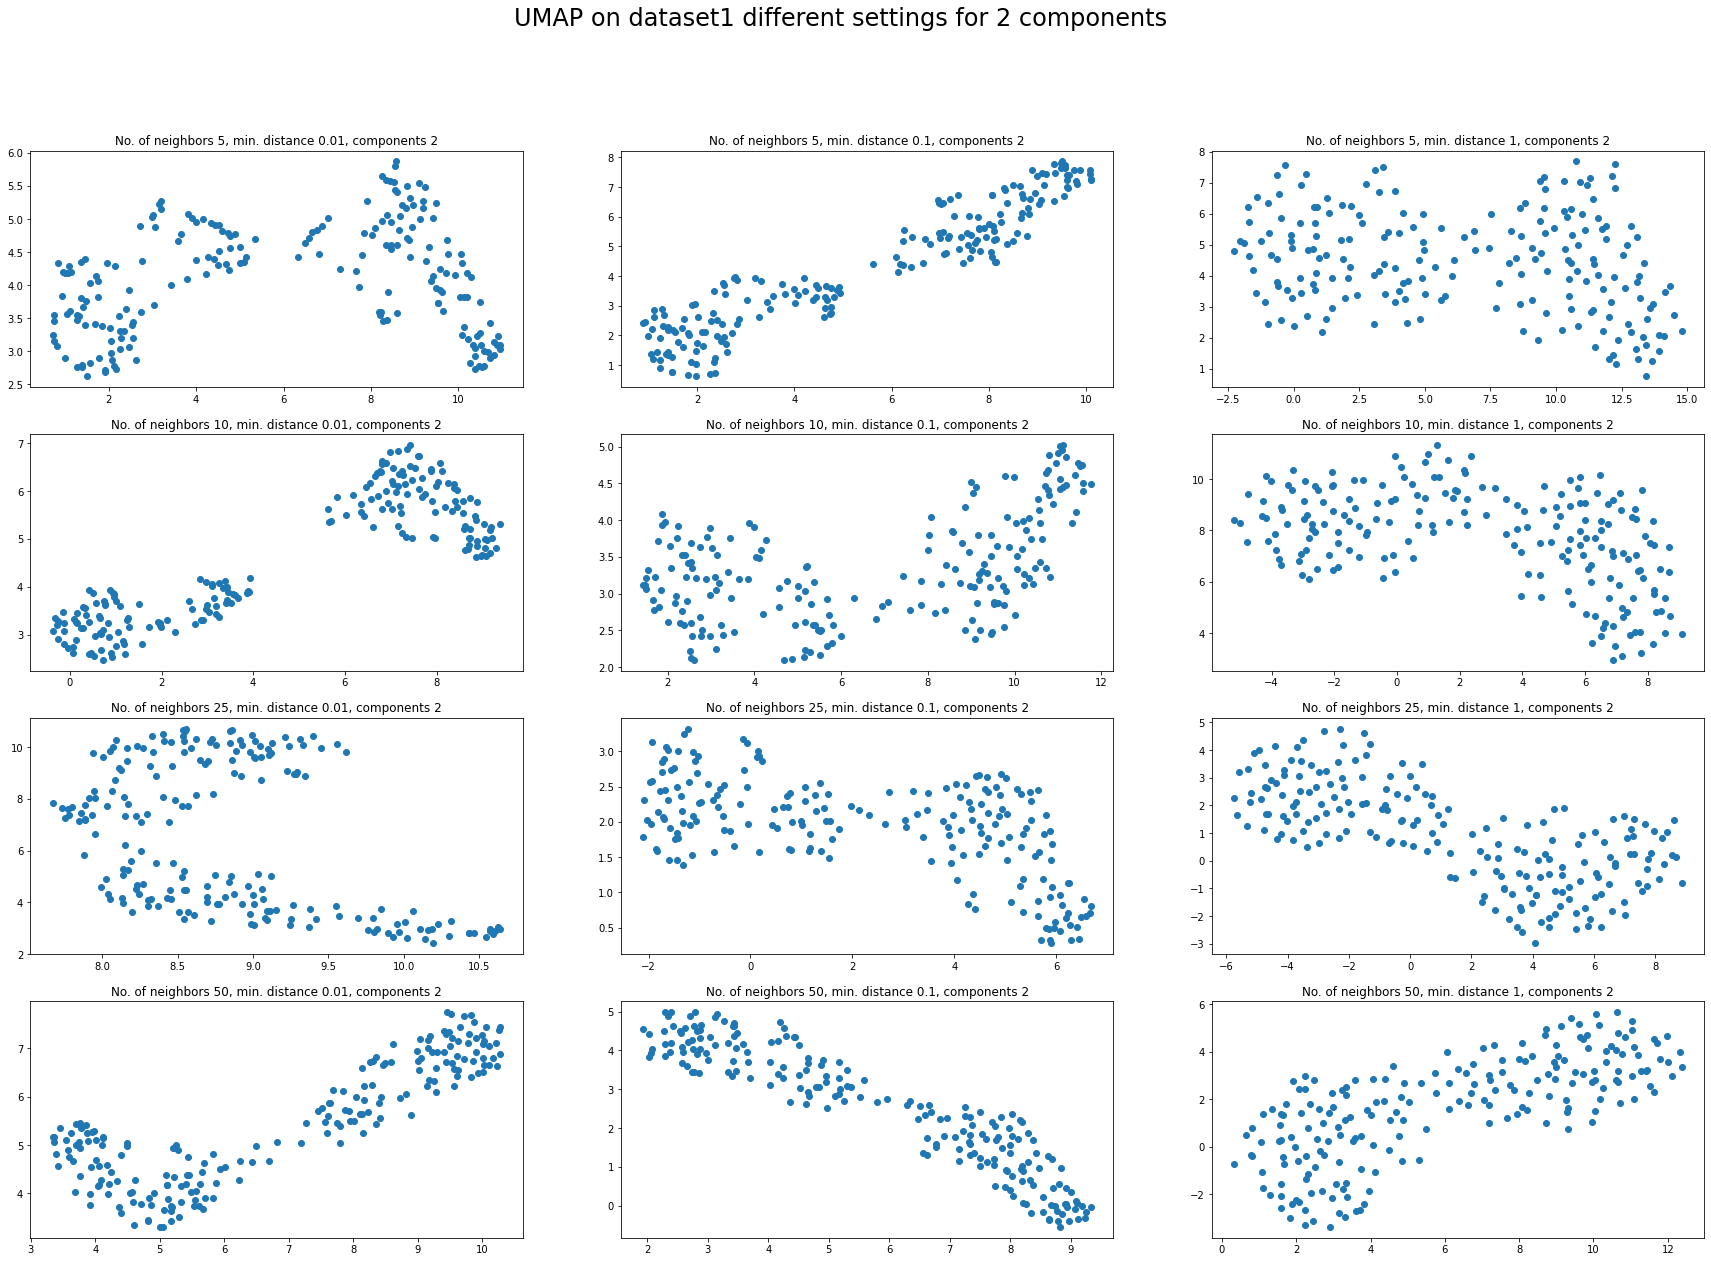

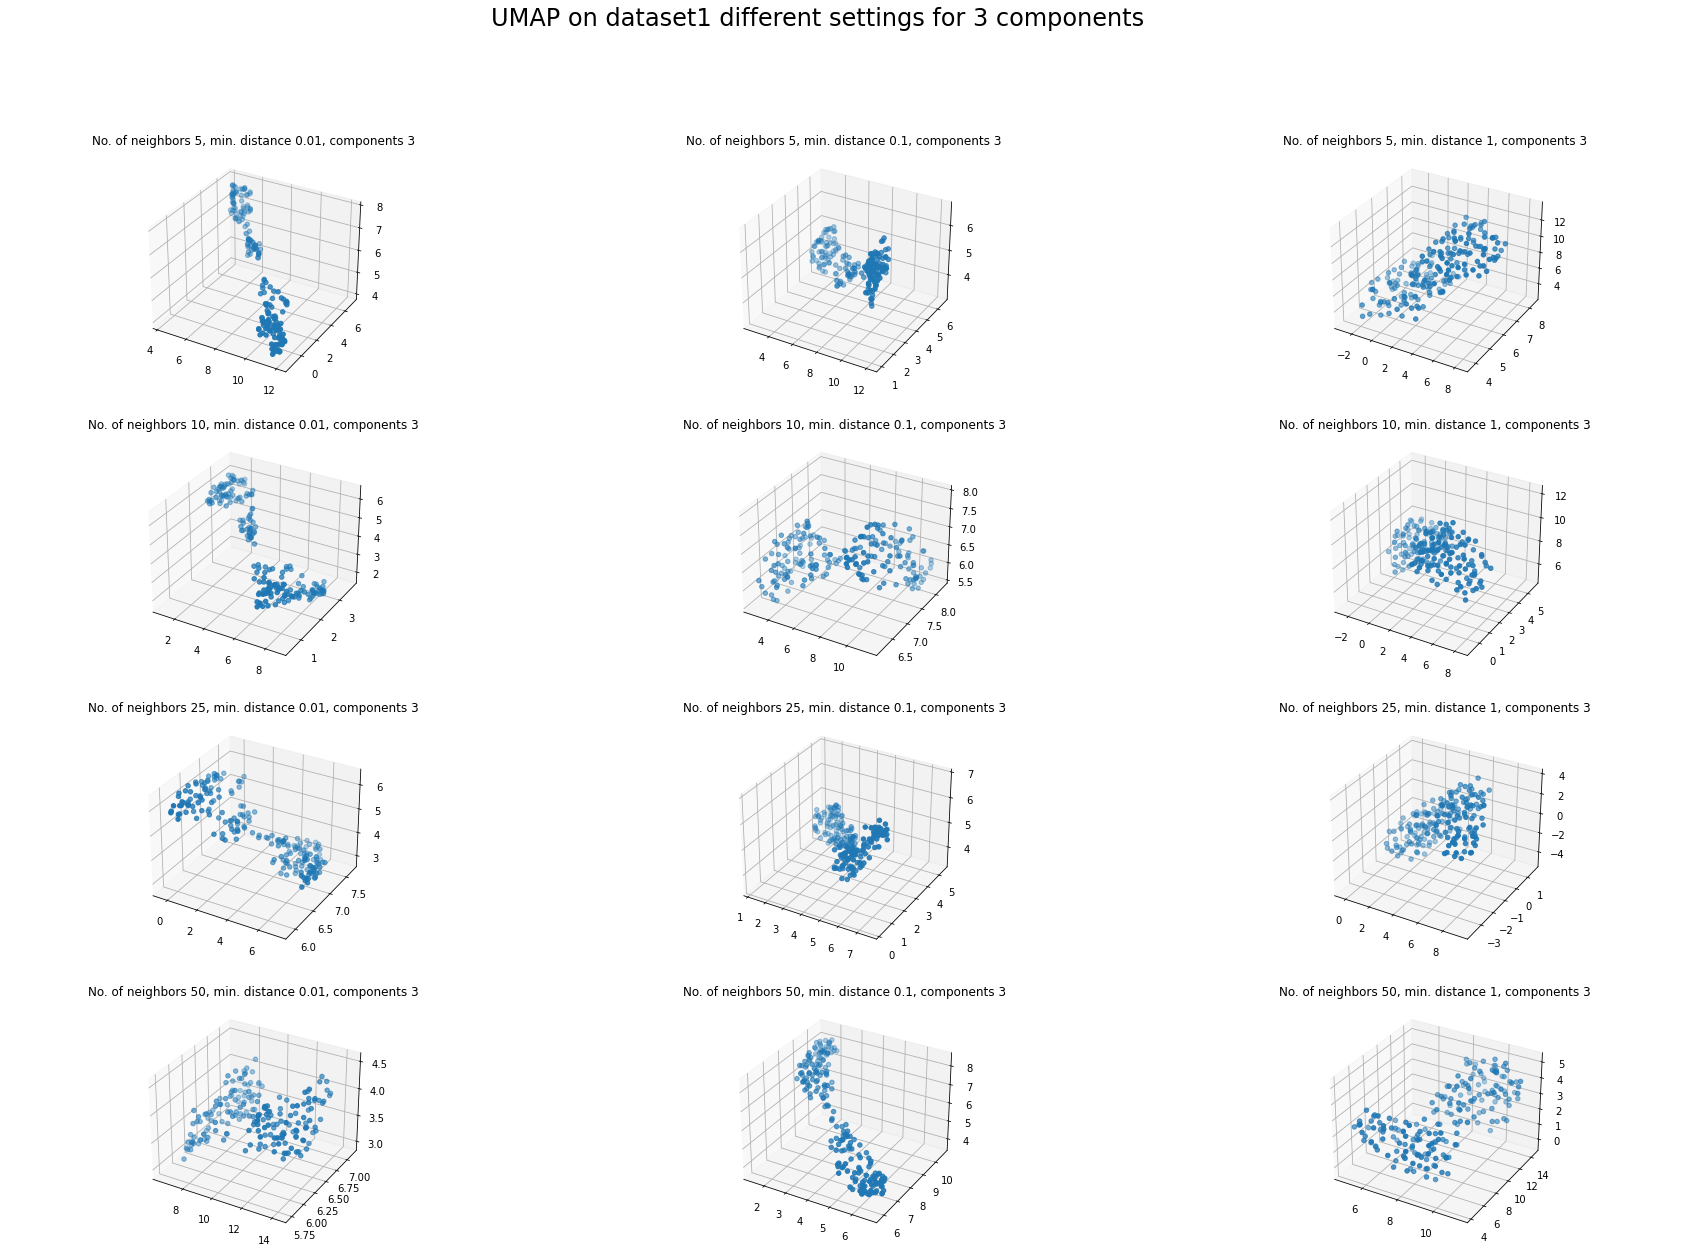

PCA chosen components: 116


/Users/vasilisstamatopoulos/opt/anaconda3/envs/ml_comp_bio/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/vasilisstamatopoulos/opt/anaconda3/envs/ml_comp_bio/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


TSNE components: 3
PCA chosen components: 116


<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

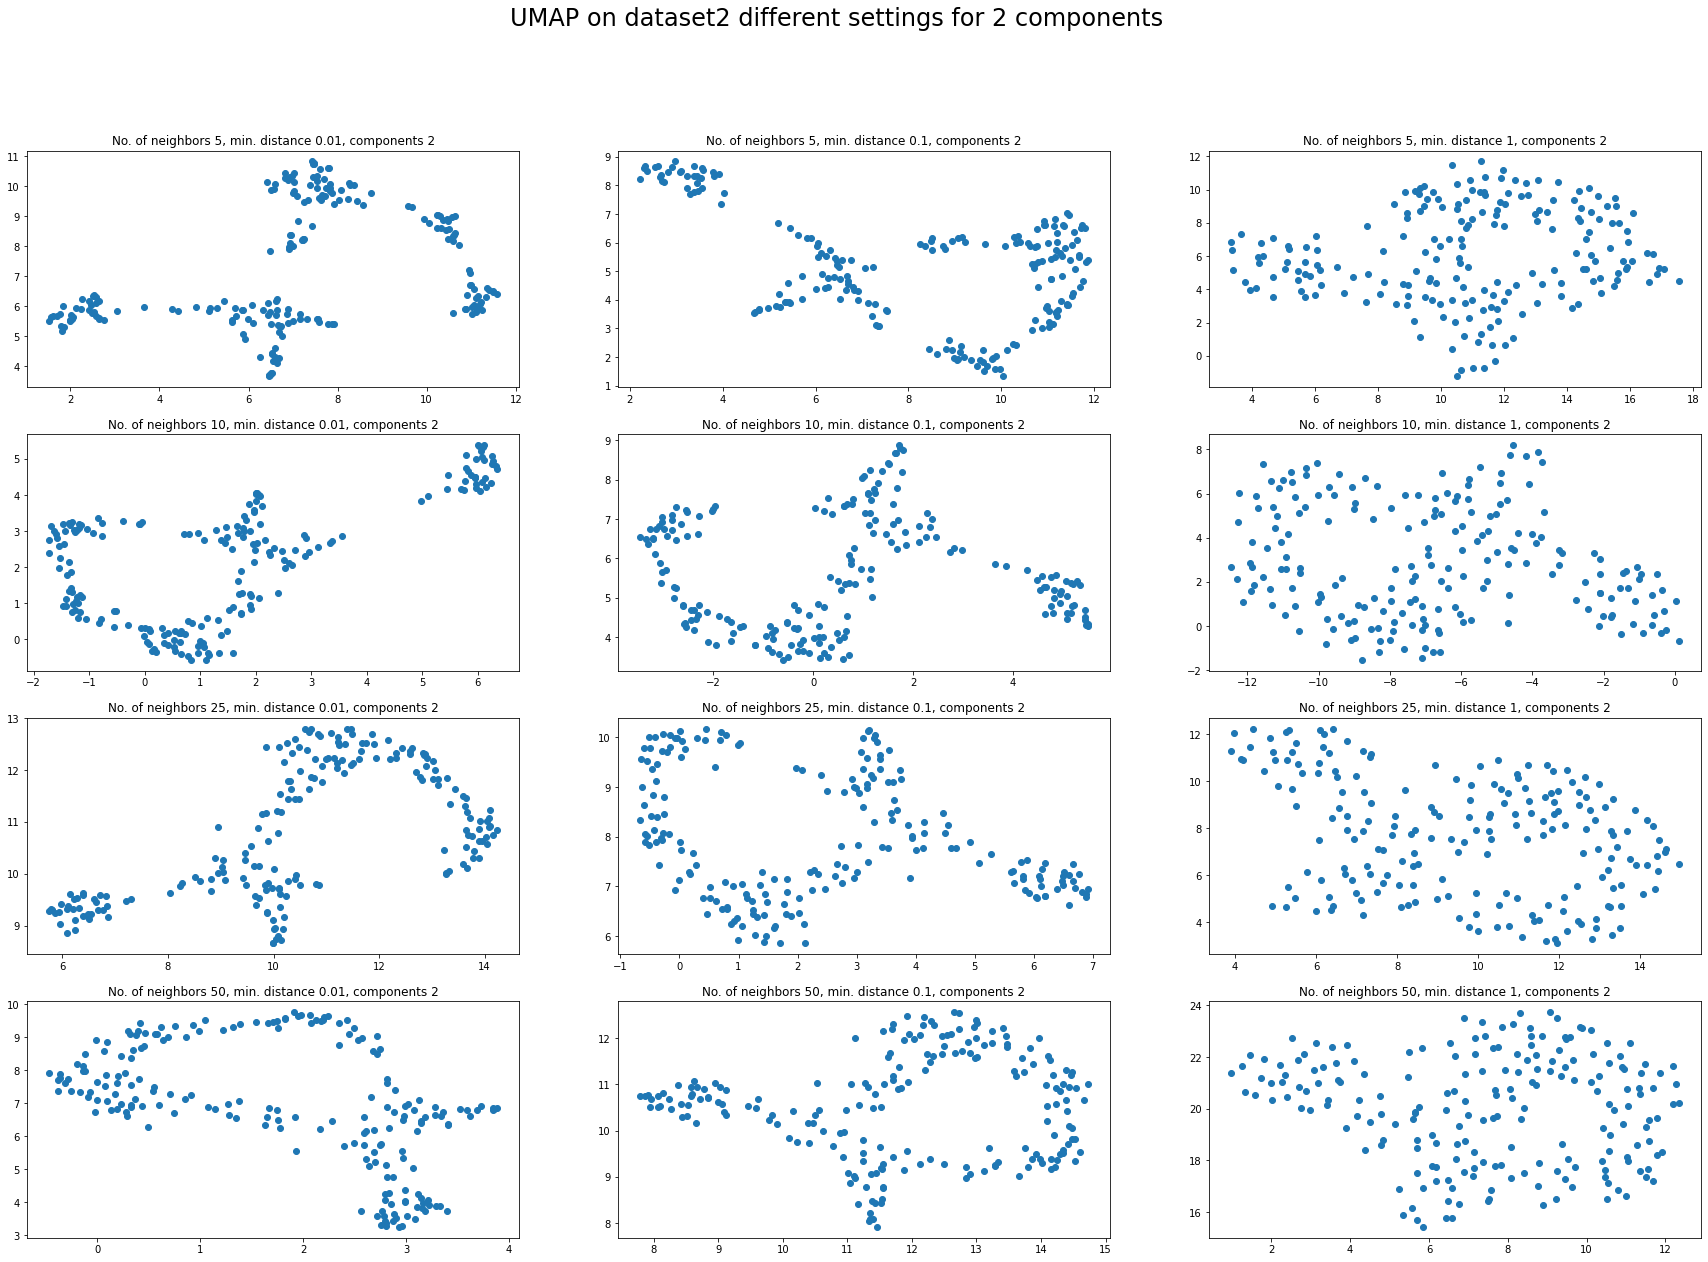

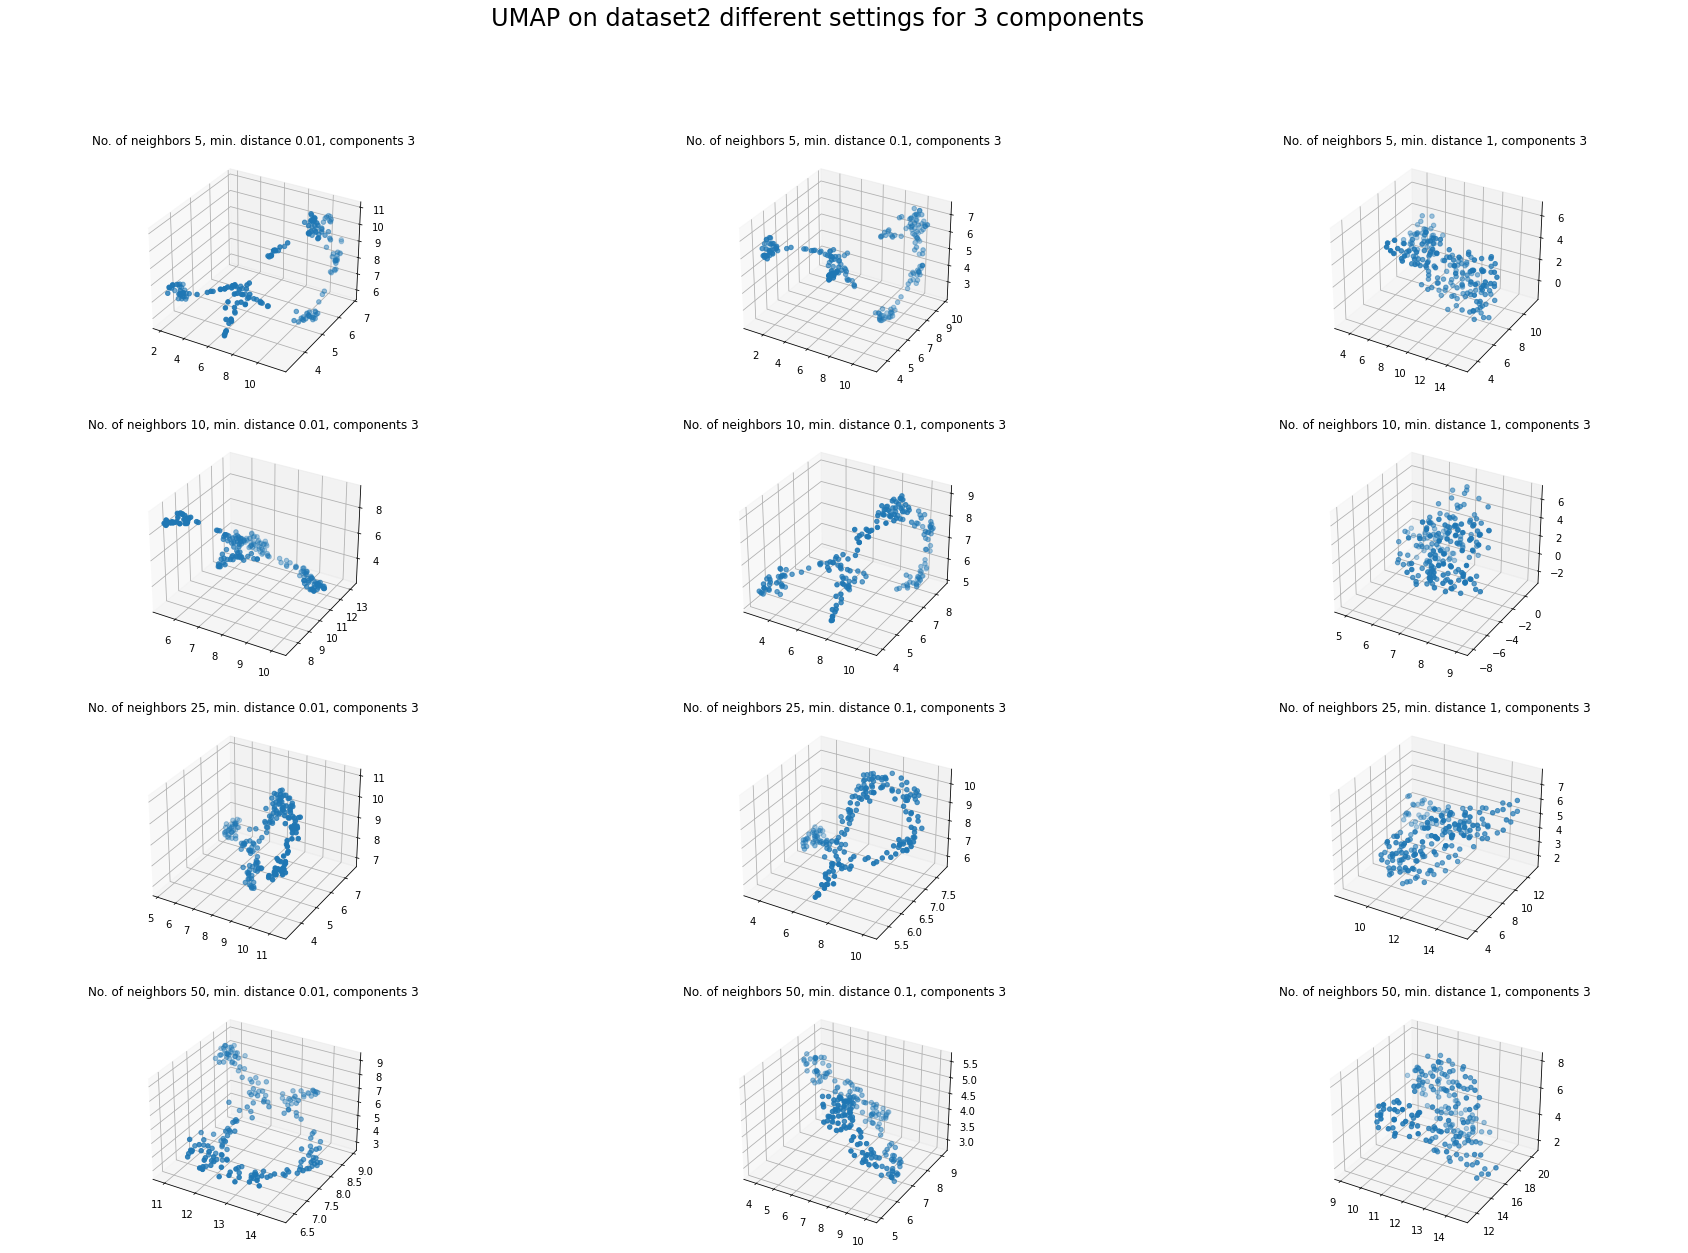

PCA chosen components: 114


/Users/vasilisstamatopoulos/opt/anaconda3/envs/ml_comp_bio/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/vasilisstamatopoulos/opt/anaconda3/envs/ml_comp_bio/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


TSNE components: 3
PCA chosen components: 114


<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

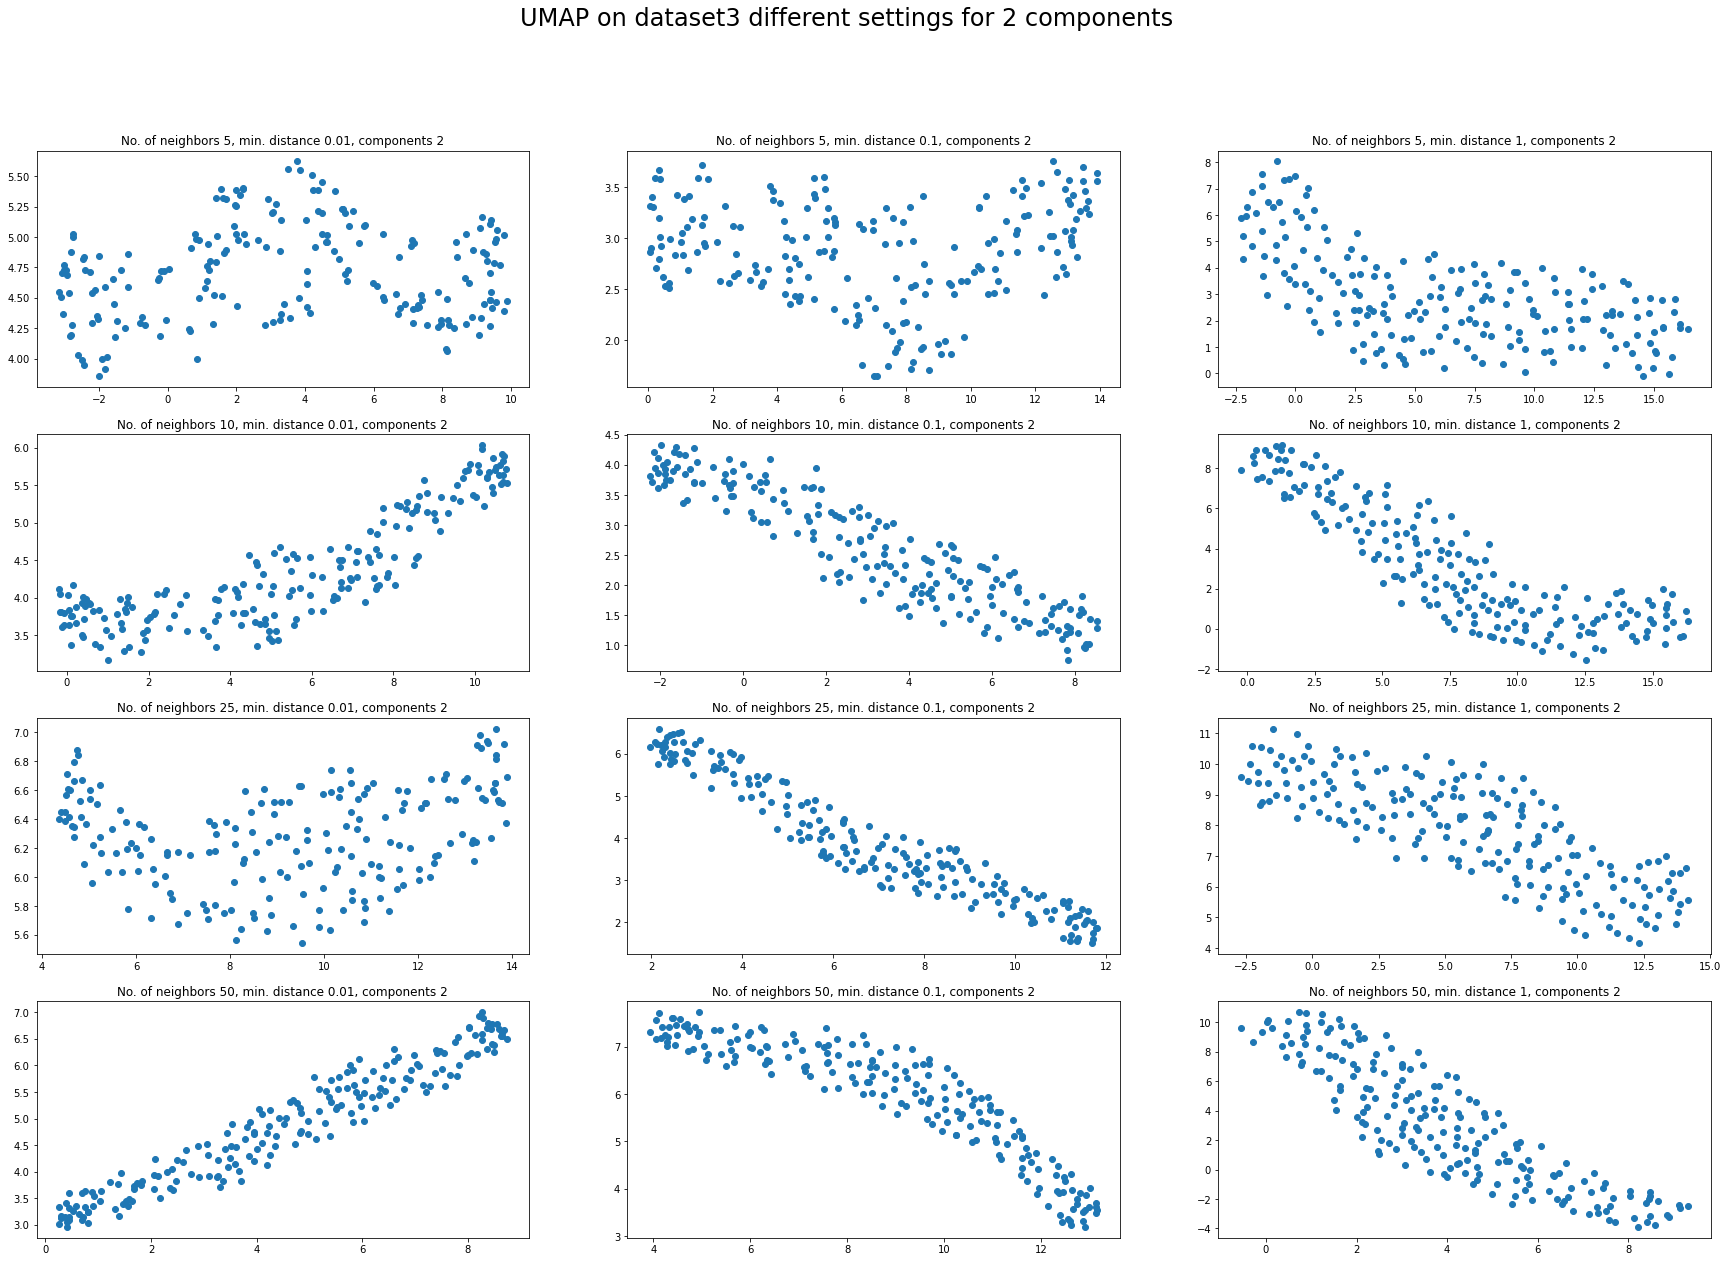

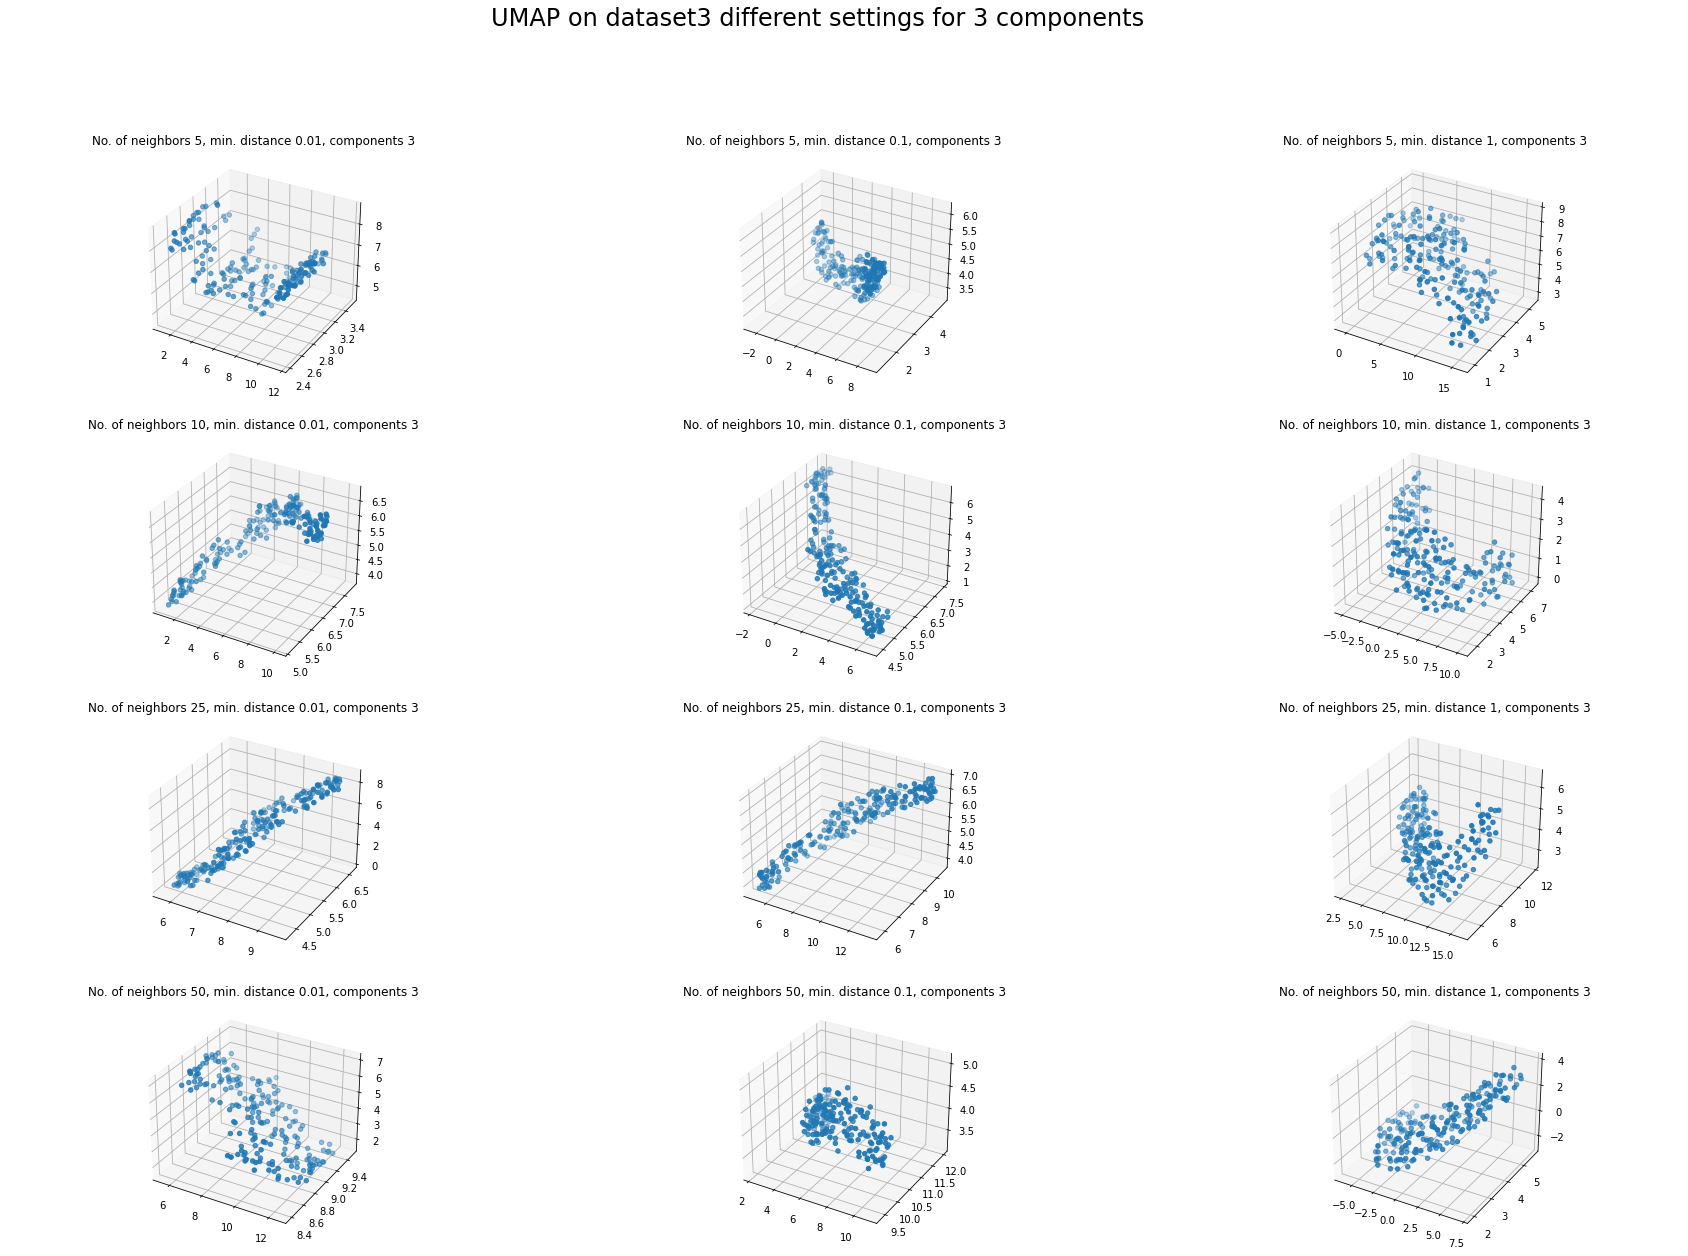

PCA chosen components: 116


/Users/vasilisstamatopoulos/opt/anaconda3/envs/ml_comp_bio/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/vasilisstamatopoulos/opt/anaconda3/envs/ml_comp_bio/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


TSNE components: 3
PCA chosen components: 116


<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

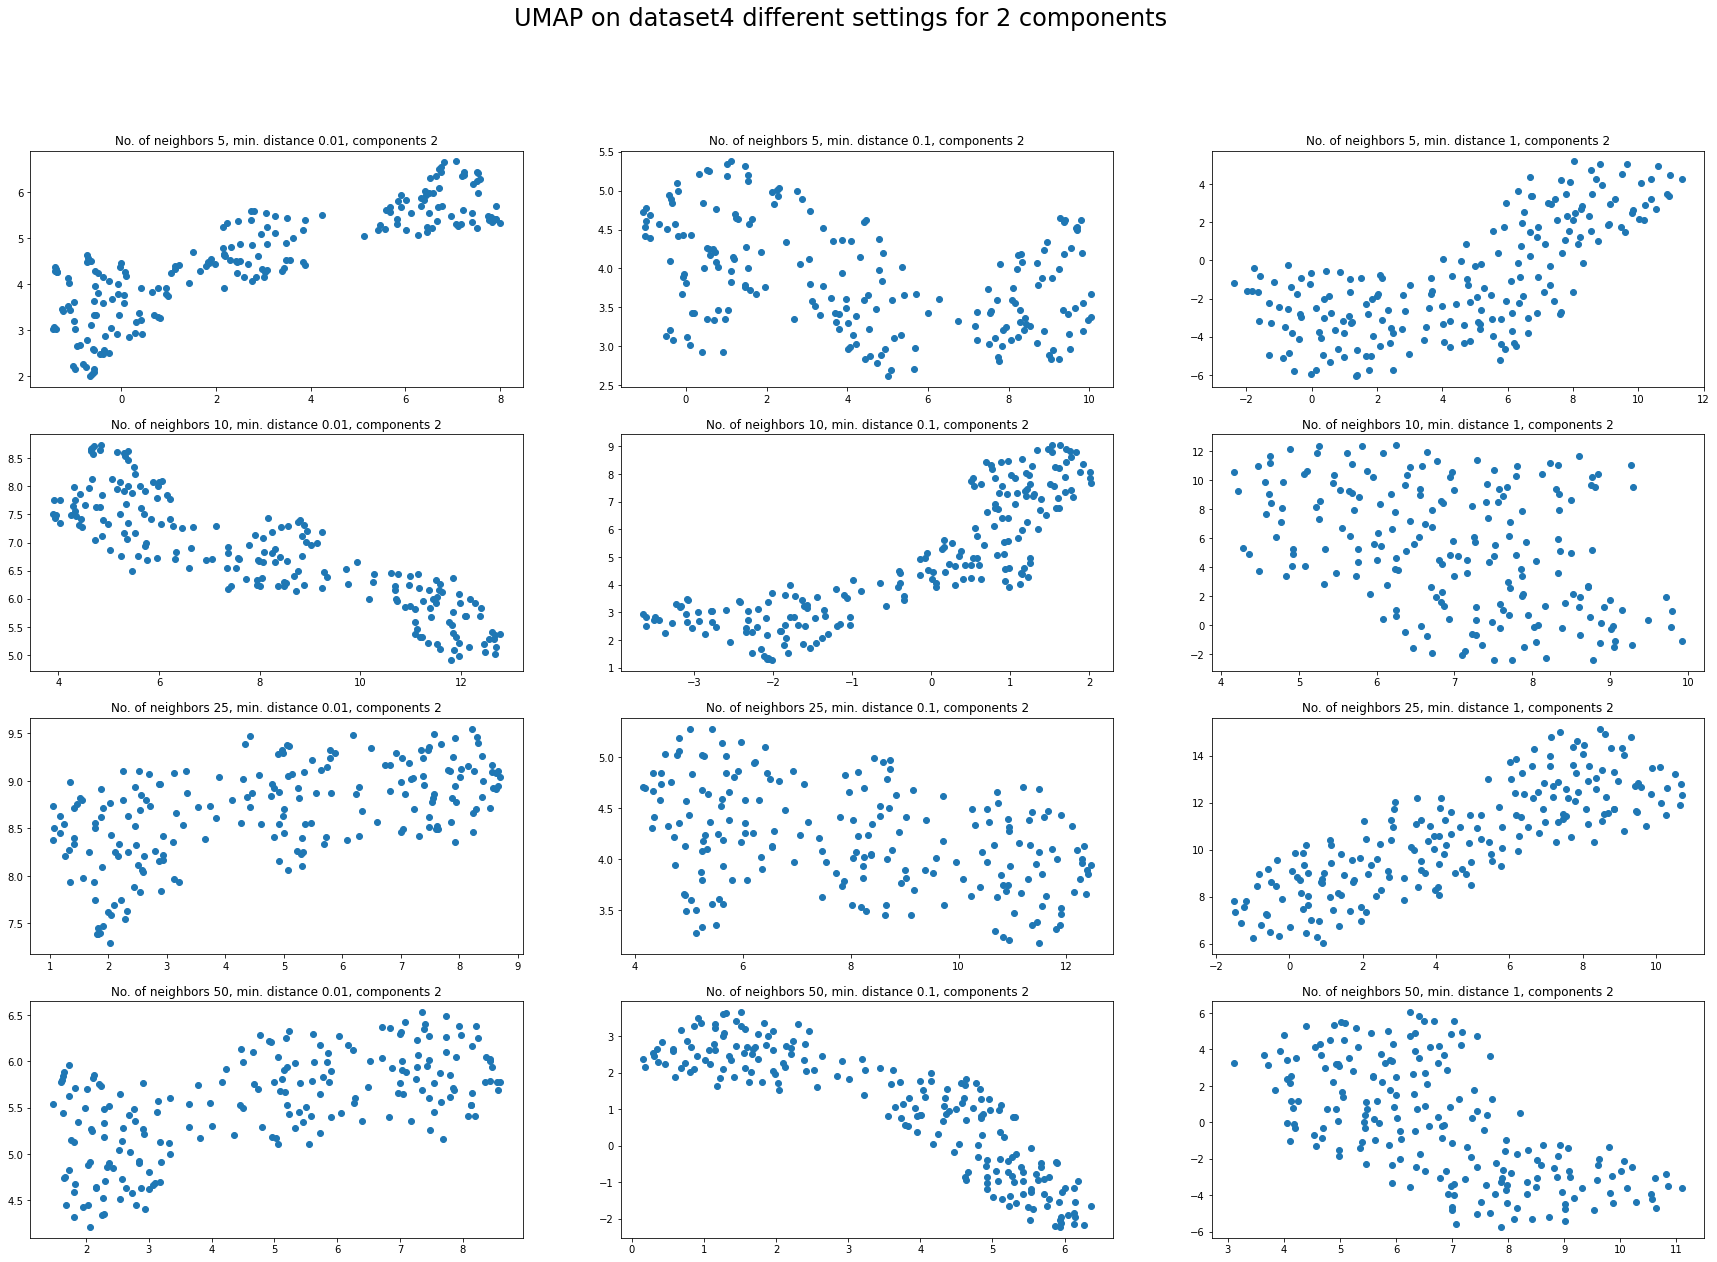

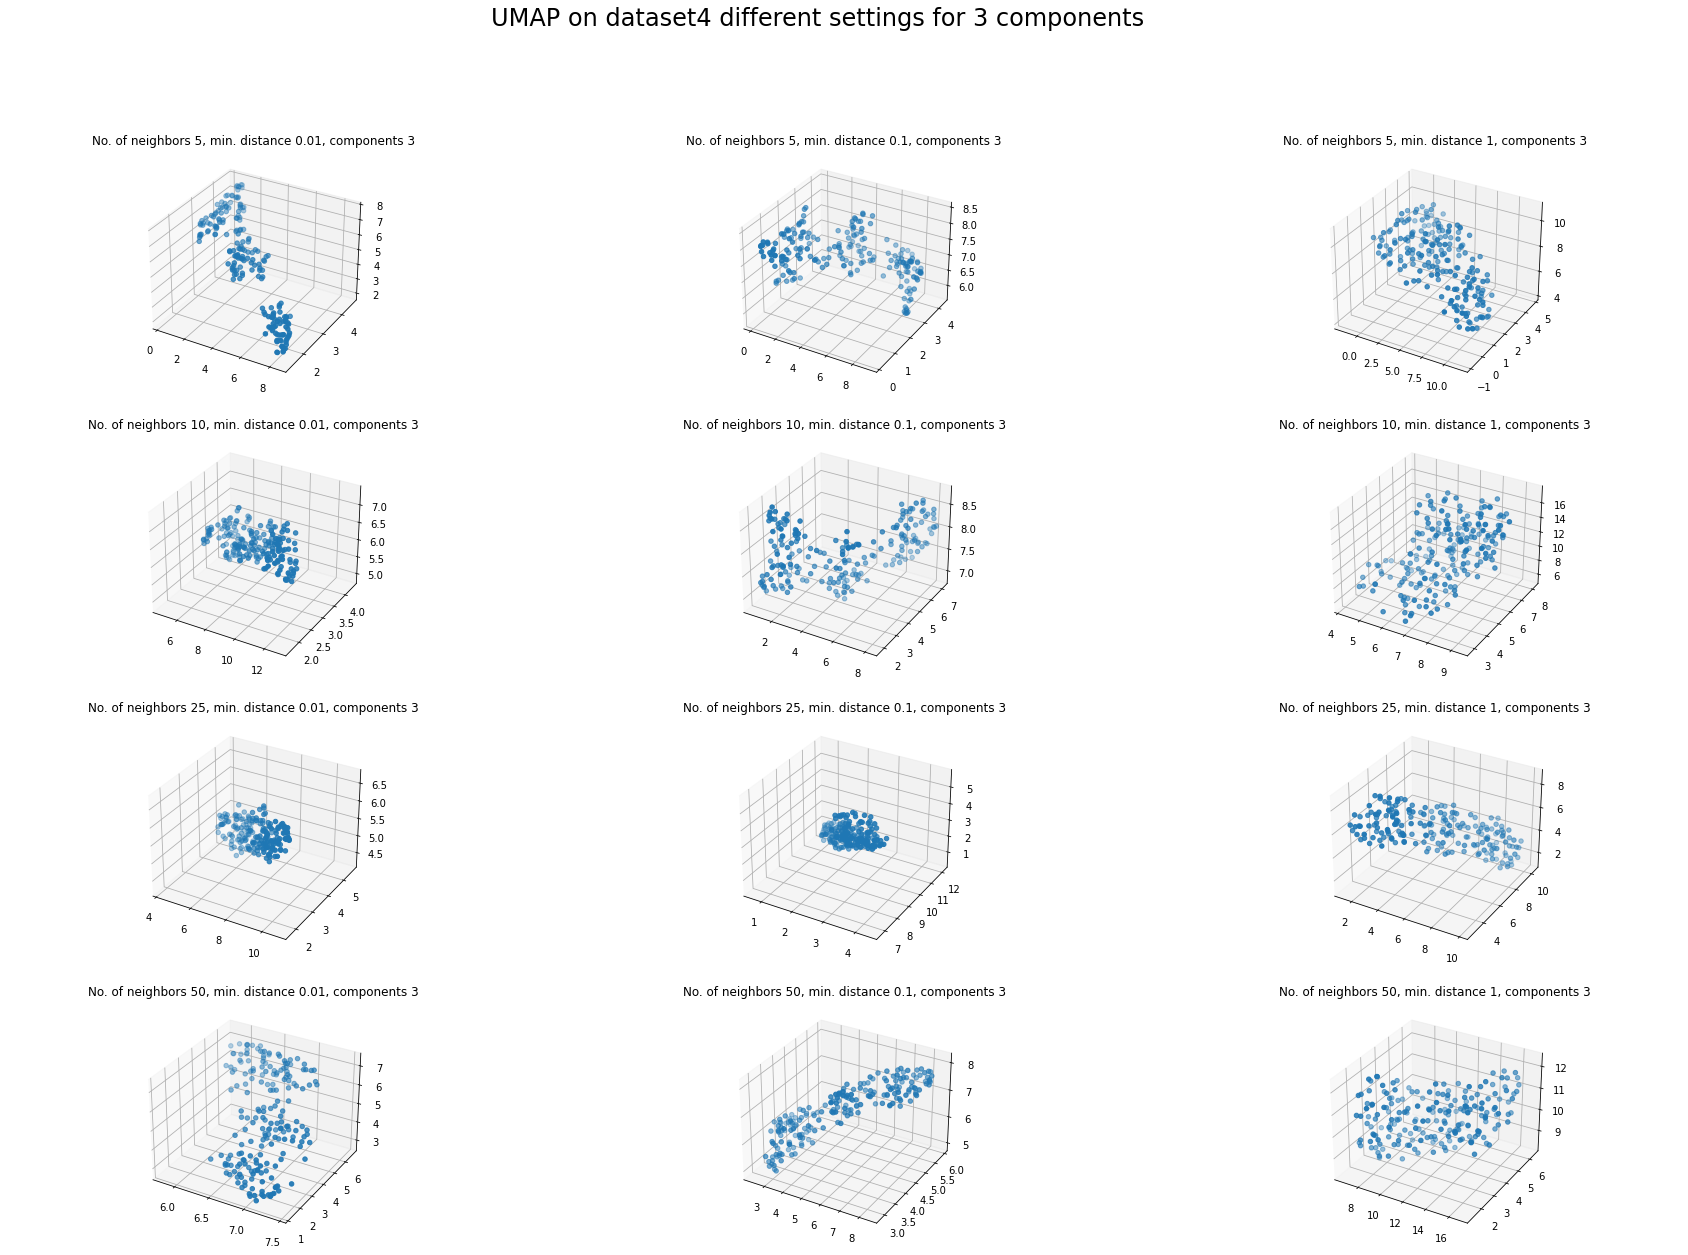

PCA chosen components: 115


/Users/vasilisstamatopoulos/opt/anaconda3/envs/ml_comp_bio/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/vasilisstamatopoulos/opt/anaconda3/envs/ml_comp_bio/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


TSNE components: 3
PCA chosen components: 115


<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

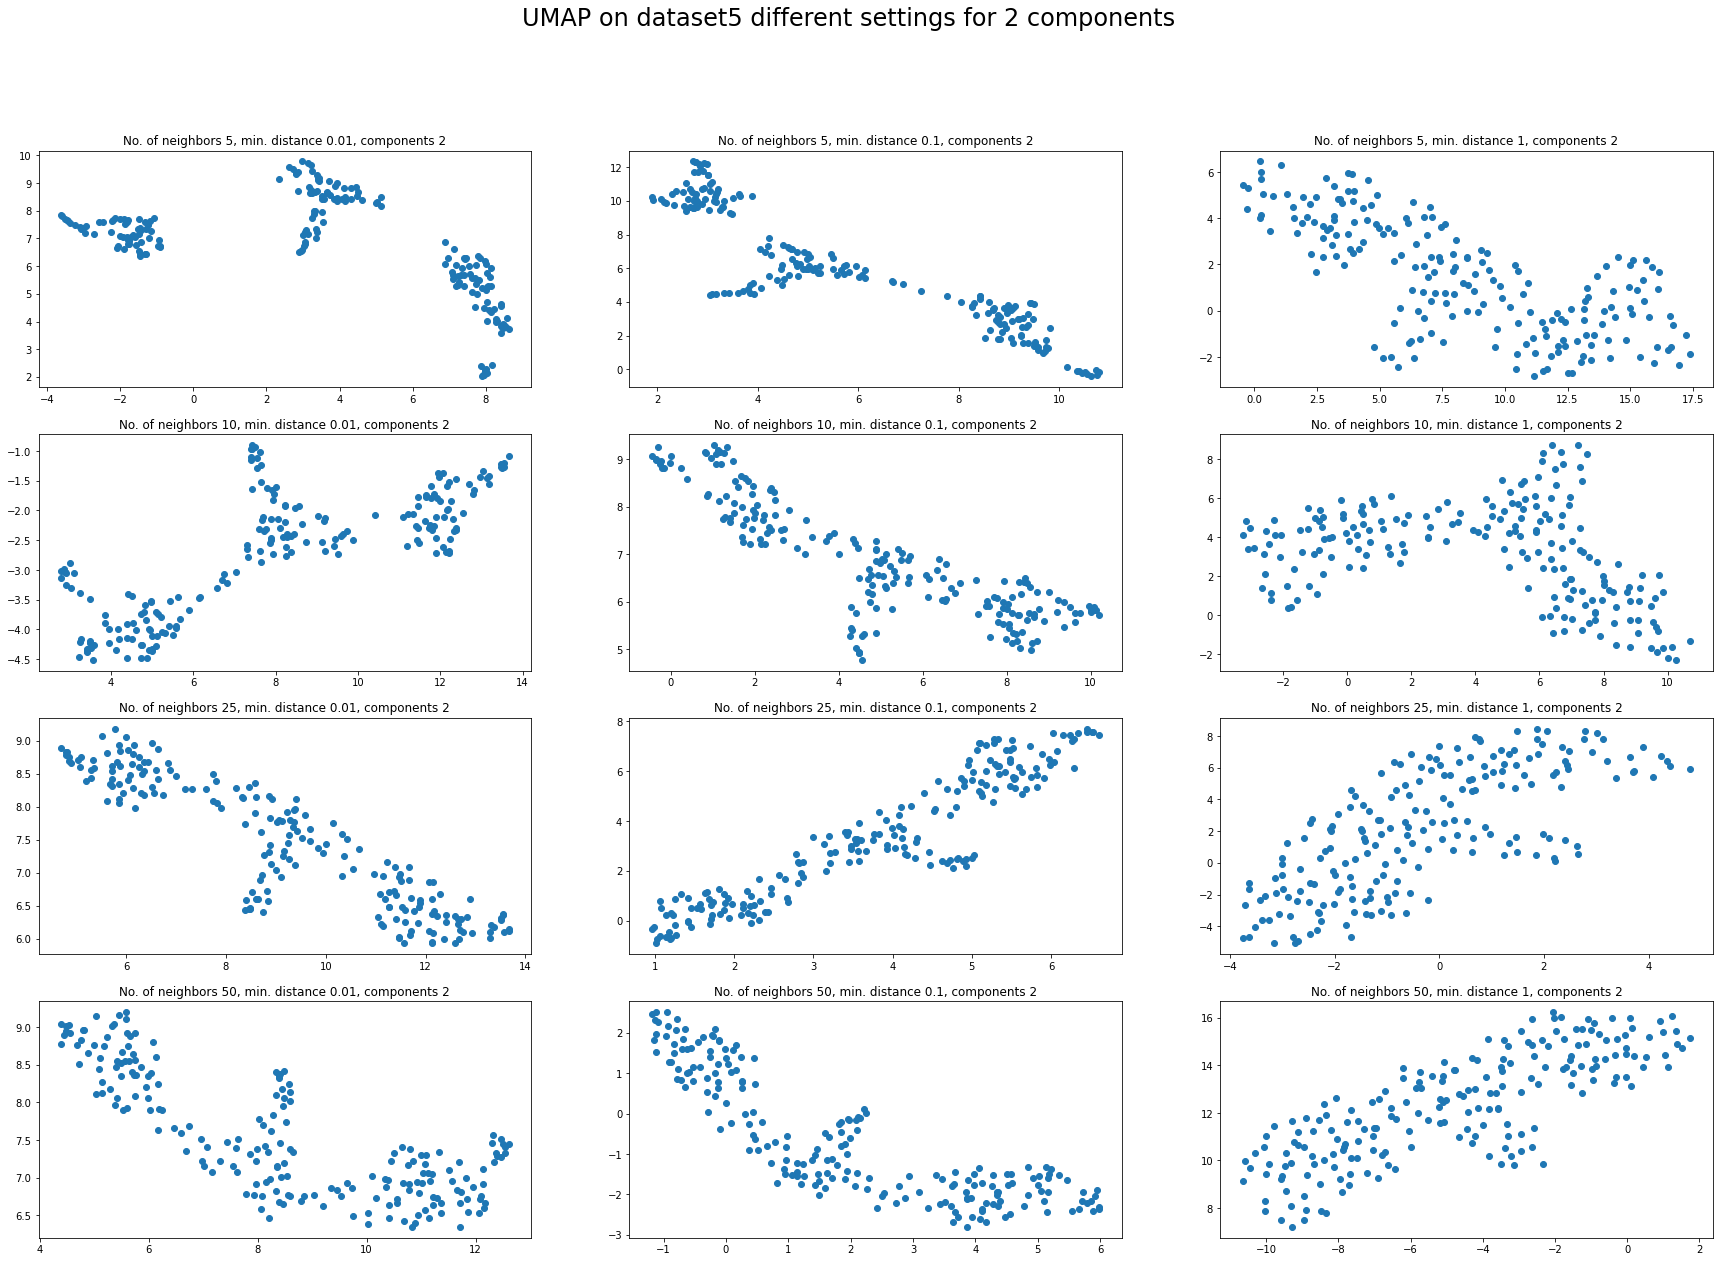

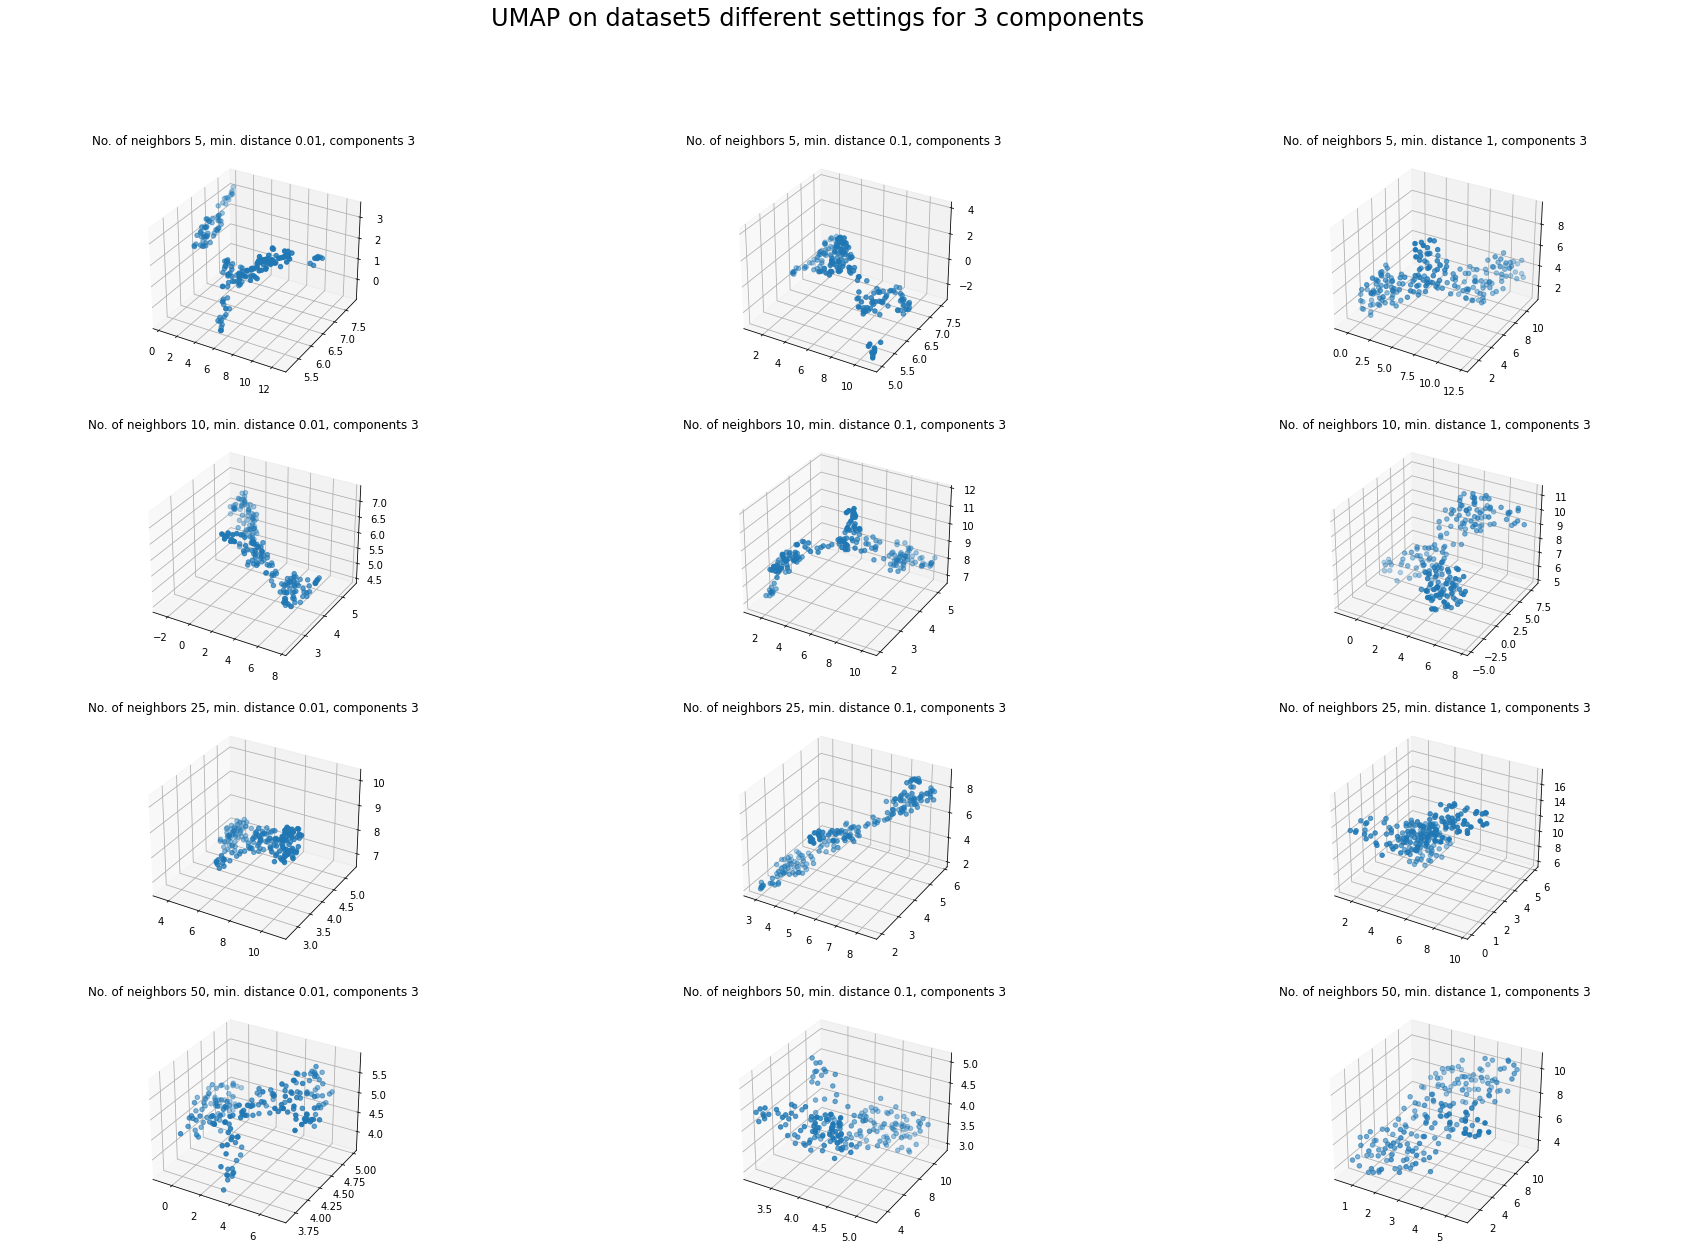

In [31]:
run('test', 'dr')

PCA chosen components: 116


<Figure size 1152x432 with 0 Axes>

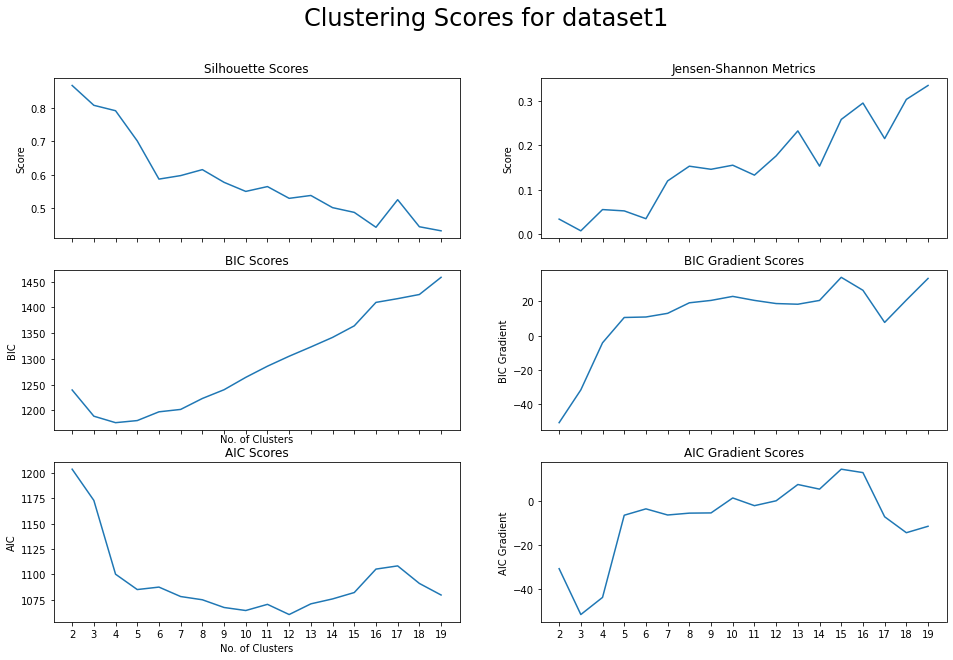

PCA chosen components: 116


<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

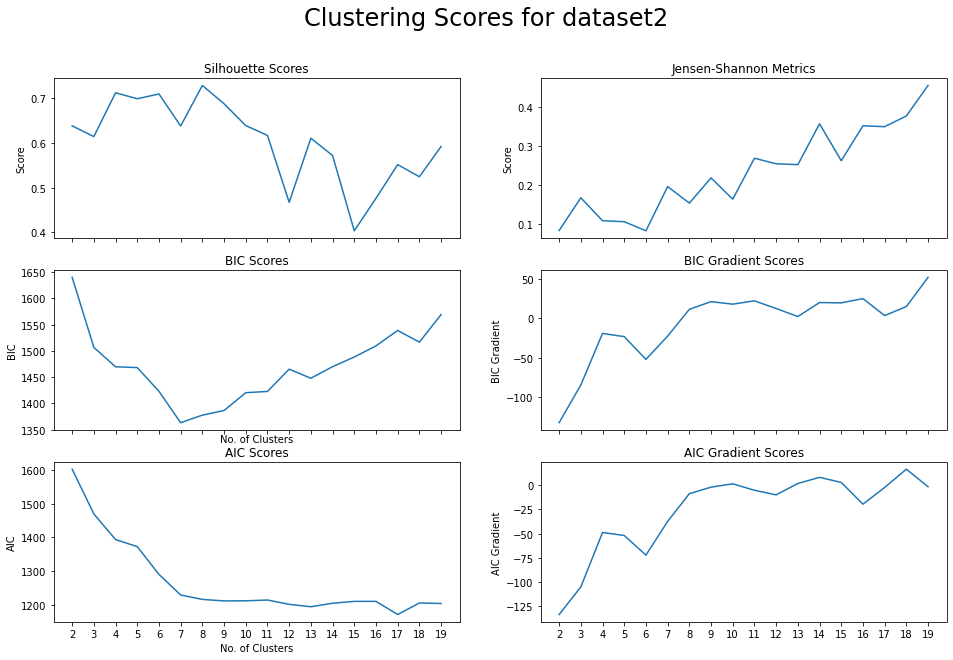

PCA chosen components: 114


<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

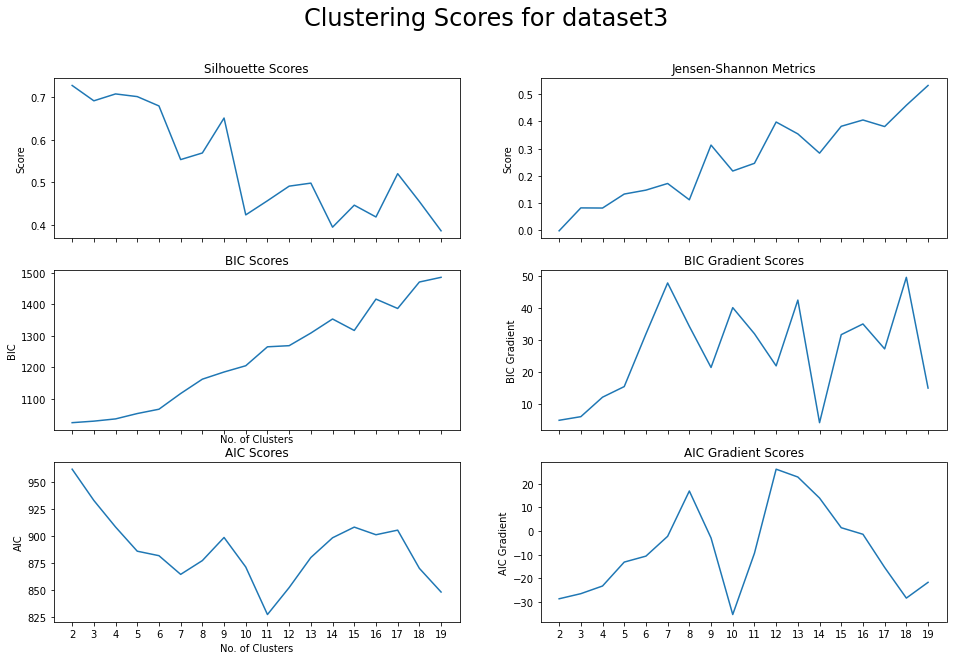

PCA chosen components: 116


<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

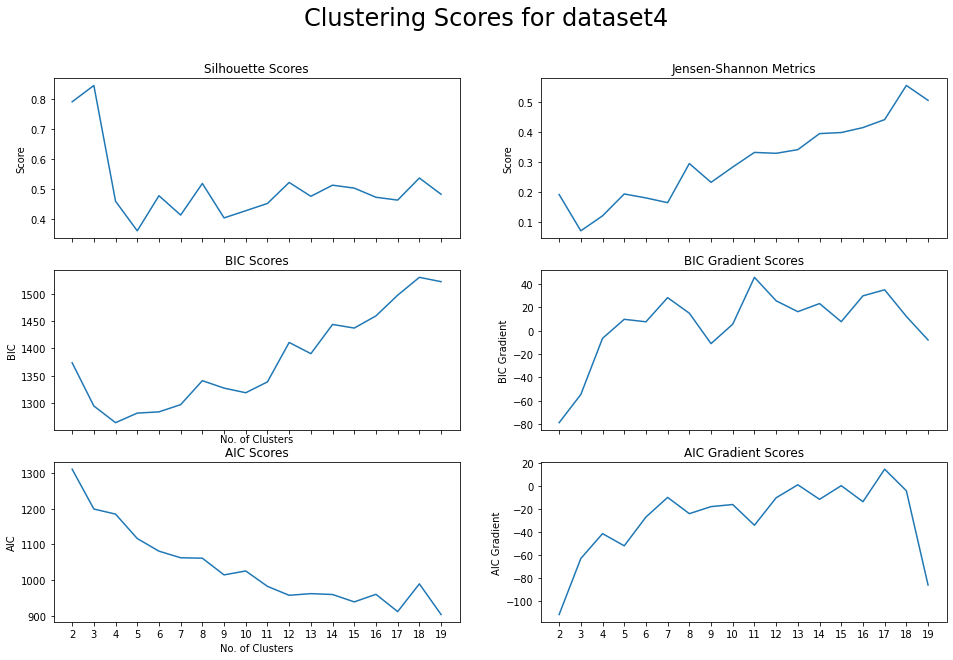

PCA chosen components: 115


<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

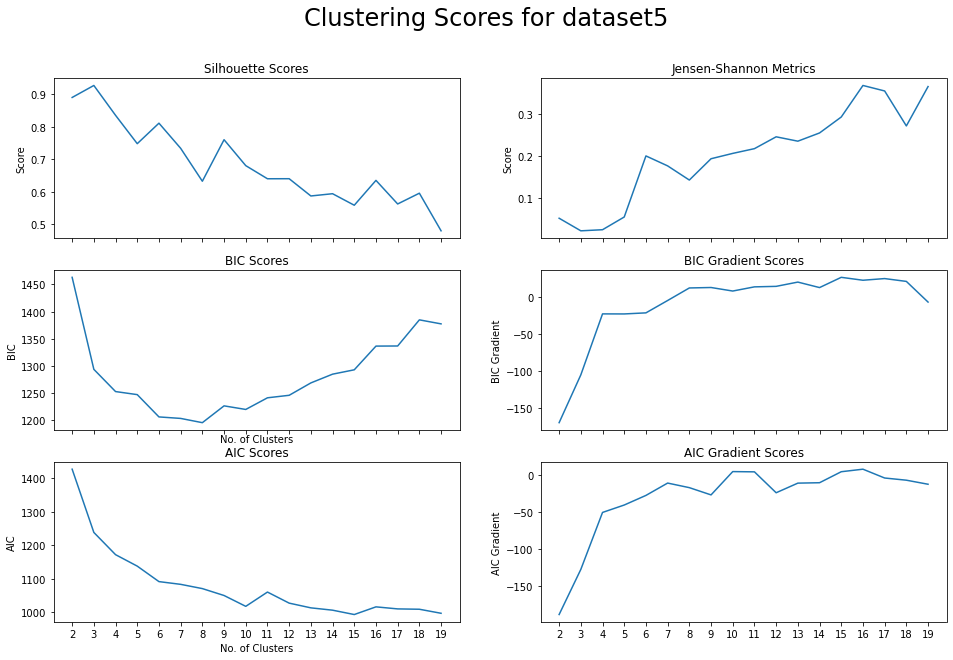

<Figure size 1152x432 with 0 Axes>

In [31]:
run('test', '_')